<a href="https://colab.research.google.com/github/AdityaPunetha/Pytorch-MNIST-GAN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from torch.utils.data import DataLoader

In [21]:
import torch.nn as nn

## Load the data
Normalizing them will change the pixel values from the range [0, 1] to the range [-1, 1]

In [3]:
mnist = MNIST(root ="data", train=True,download = True,transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [8]:
img, label = mnist[0]
print("Label: ",label)
torch.min(img),torch.max(img)

Label:  5


(tensor(-1.), tensor(1.))

Define a denormalizer to view the image

In [10]:
def denorm(x):
  out = (x+1)/2
  return out.clamp(0,1)

5

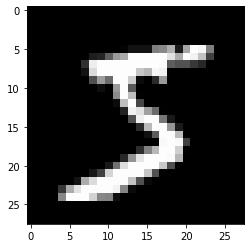

In [14]:
img_norm = denorm(img)
plt.imshow(img_norm[0],cmap ="gray")
label

In [16]:
batch_size = 100
data_loader = DataLoader(mnist,batch_size,shuffle = True)

first batch
torch.Size([100, 1, 28, 28])
tensor([0, 5, 5, 6, 9, 1, 5, 1, 2, 2, 6, 0, 7, 8, 5, 2, 2, 1, 0, 7, 5, 5, 0, 1,
        5, 8, 5, 4, 2, 6, 4, 5, 4, 6, 8, 9, 5, 6, 5, 8, 4, 6, 0, 8, 6, 9, 8, 8,
        0, 9, 4, 6, 3, 1, 3, 7, 5, 0, 9, 8, 3, 1, 1, 7, 3, 4, 8, 0, 3, 4, 1, 1,
        6, 2, 1, 6, 1, 3, 4, 3, 6, 5, 0, 7, 0, 1, 5, 8, 4, 7, 9, 9, 6, 2, 2, 0,
        0, 0, 3, 8])


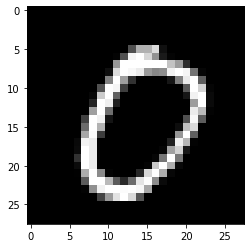

In [17]:
for img_batch,label_batch in data_loader:
  print('first batch')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0],cmap = 'gray')
  print(label_batch)
  break

# Discriminator Network

In [23]:
image_size = 28*28
hidden_size = 256

In [24]:
D = nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)

Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient. - Source

In [25]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Generator Network

In [26]:
latent_size = 64

In [27]:
G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()
)

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - Source

In [31]:
y = G(torch.randn(2,latent_size))
gen_image = denorm(y.reshape((-1,28,28)).detach())

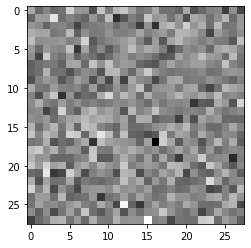

In [32]:
plt.imshow(gen_image[0], cmap='gray')

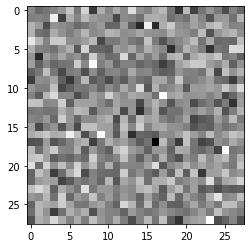

In [33]:
plt.imshow(gen_image[1], cmap='gray')

# Discriminator Training
Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

In [35]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
  real_labels = torch.ones(batch_size,1).to(device)
  fake_labels = torch.zeroes(batch_size,1).to(device)

  outputs = D(images)
  d_loss_real = criterion(outputs,real_labels)
  real_score = outputs

  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake=criterion(outputs,fake_labels)

  d_loss = d_loss_fake + d_loss_real

  reset_grad()

  d_loss.backward()

  d_optimiser.step()
  
  return d_loss, real_score, fake_score

# Generator Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
D.to(device)

In [ ]:
G.to(device)